In [123]:
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
from functions import *

In [125]:
#GRAPH STRUCTURE OPTIMIZATION TEST
x = np.linspace(0,math.pi,100)
y = np.sin(x)*np.exp(x)#2*x+1
data = {"x":x,"y":y}

/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:304: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:304: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:304: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-

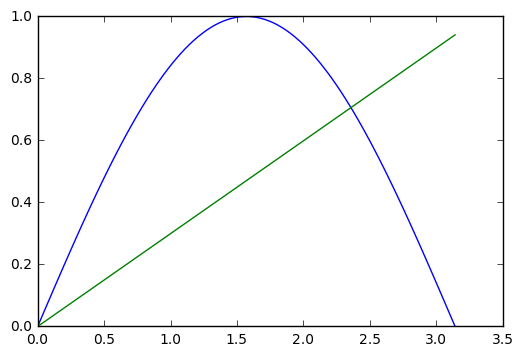

evolving generation 0 of 3


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:304: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON


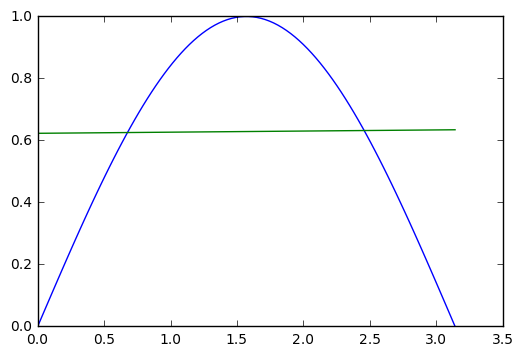

min error at generation n.0: 11.1970855364
evolving generation 1 of 3


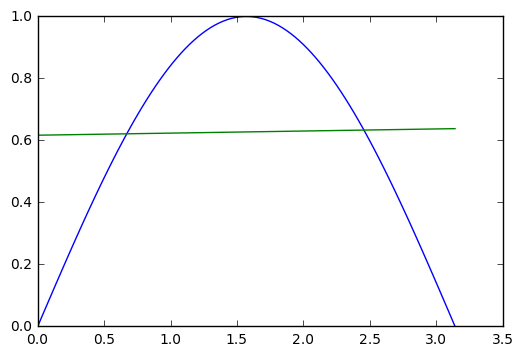

min error at generation n.1: 11.1813978926
evolving generation 2 of 3


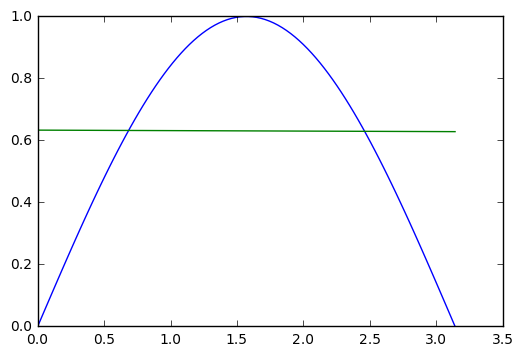

min error at generation n.2: 11.4600942939


In [121]:
%lprun -f evolution evolution(data, 3)

/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:304: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:304: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  {"type":"funct

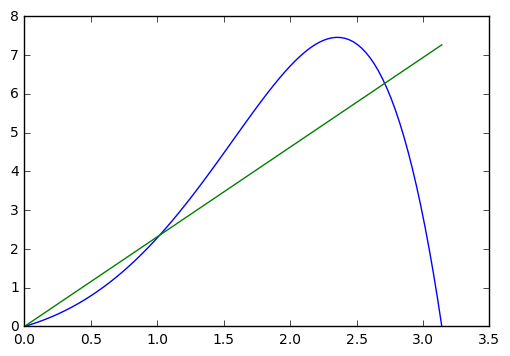

evolving generation 0 of 100


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:304: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]


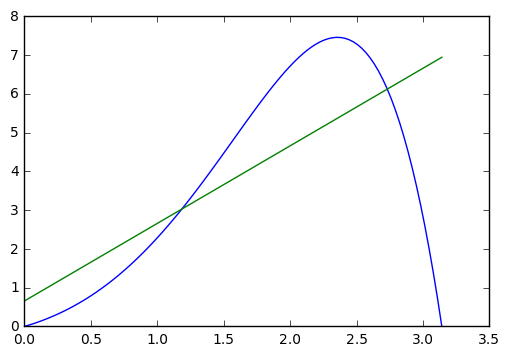

min error at generation n.0: 325.119511862
evolving generation 1 of 100


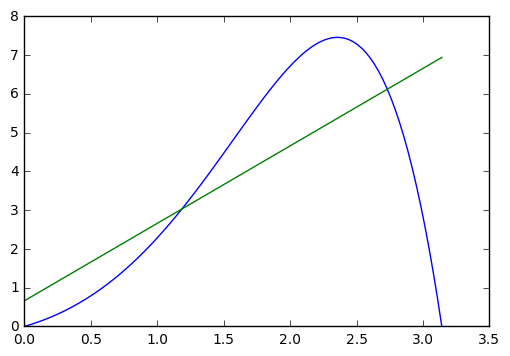

min error at generation n.1: 324.987615592
evolving generation 2 of 100


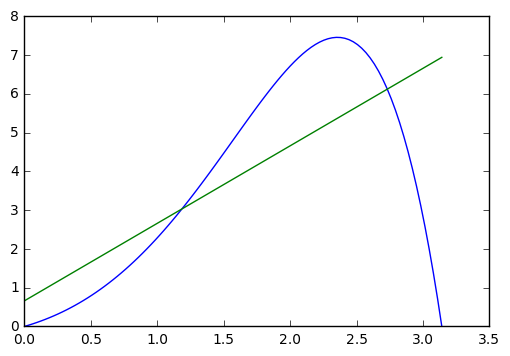

min error at generation n.2: 324.90497978
evolving generation 3 of 100


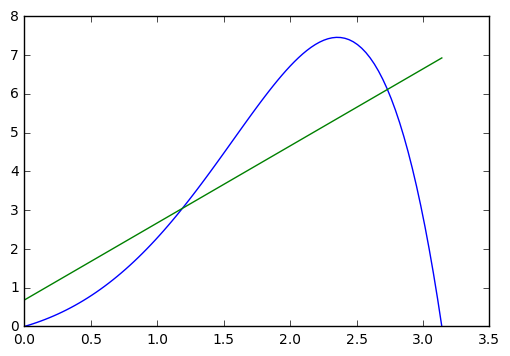

min error at generation n.3: 324.964931312
evolving generation 4 of 100


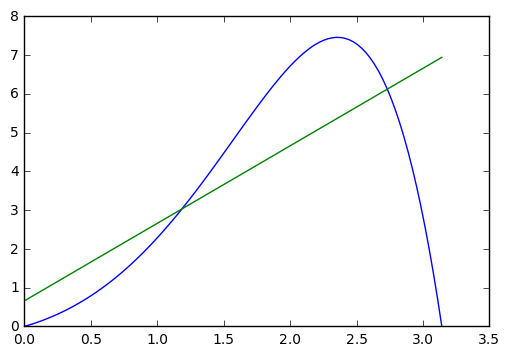

min error at generation n.4: 324.869770839
evolving generation 5 of 100


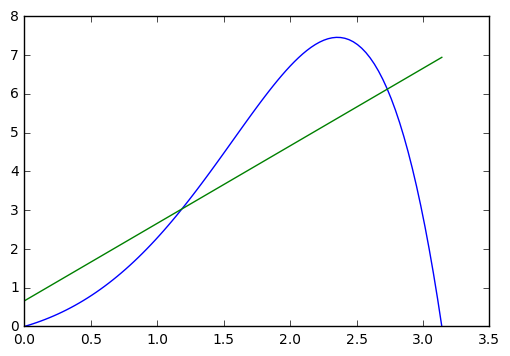

min error at generation n.5: 324.913502052
evolving generation 6 of 100


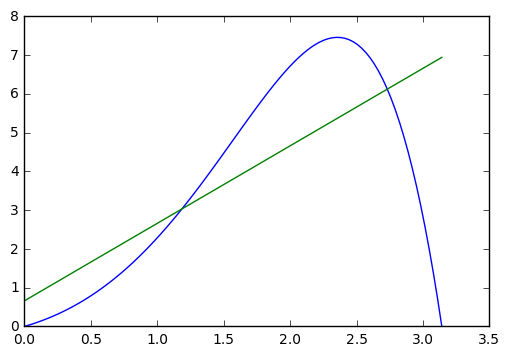

min error at generation n.6: 324.885032012
evolving generation 7 of 100


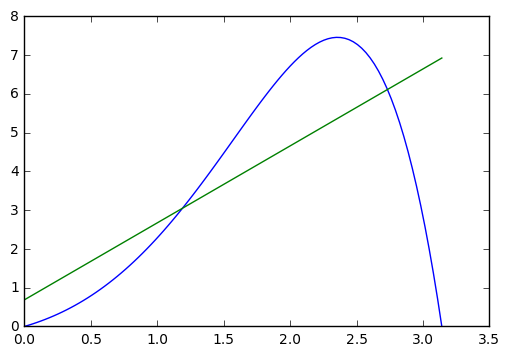

min error at generation n.7: 324.964467151
evolving generation 8 of 100


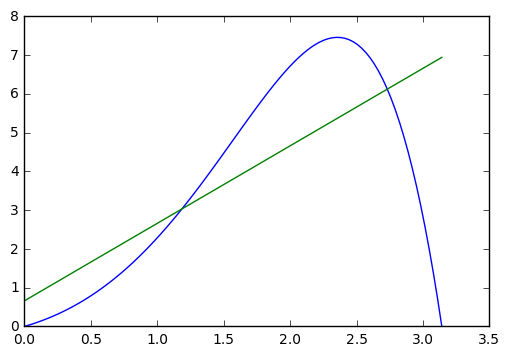

min error at generation n.8: 324.83409436
evolving generation 9 of 100


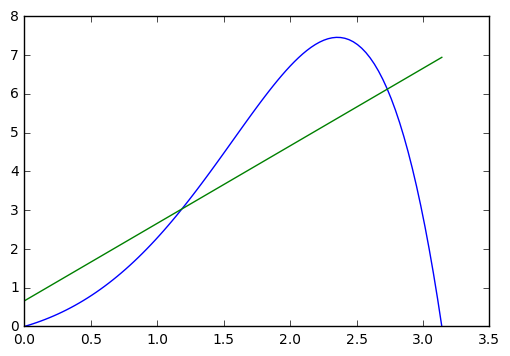

min error at generation n.9: 324.84378989
evolving generation 10 of 100


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:17: RuntimeWarning: invalid value encountered in double_scalars
  {"type":"function","function":lambda a:a[0]*a[1],"symbol":"*"},


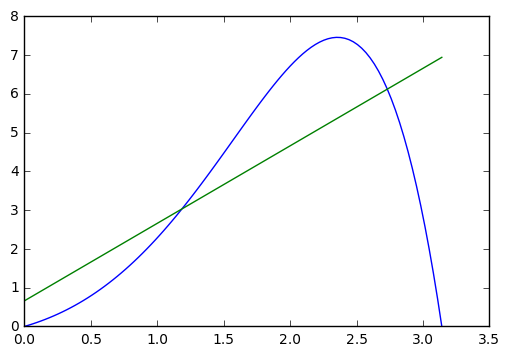

min error at generation n.10: 324.850263193
evolving generation 11 of 100


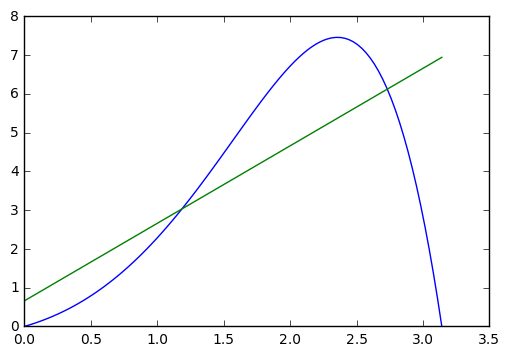

min error at generation n.11: 325.12084563
evolving generation 12 of 100


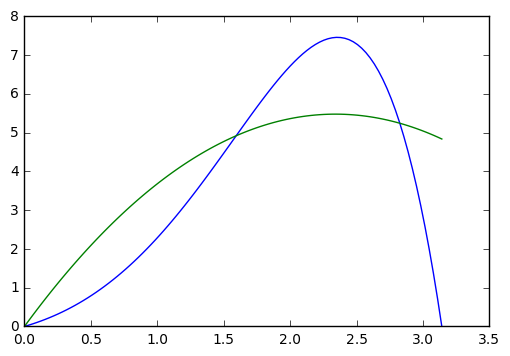

min error at generation n.12: 325.196873676
evolving generation 13 of 100


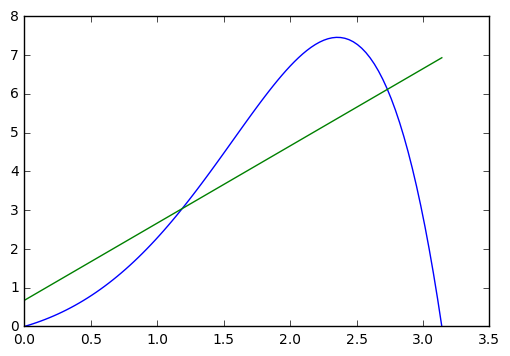

min error at generation n.13: 325.010478212
evolving generation 14 of 100


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:16: RuntimeWarning: invalid value encountered in double_scalars
  {"type":"function","function":lambda a:a[0]-a[1],"symbol":"-"},


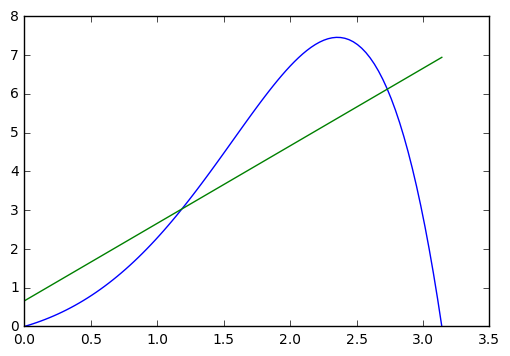

min error at generation n.14: 324.825661256
evolving generation 15 of 100


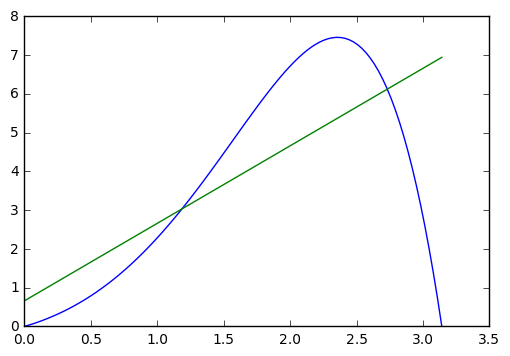

min error at generation n.15: 324.811709955
evolving generation 16 of 100


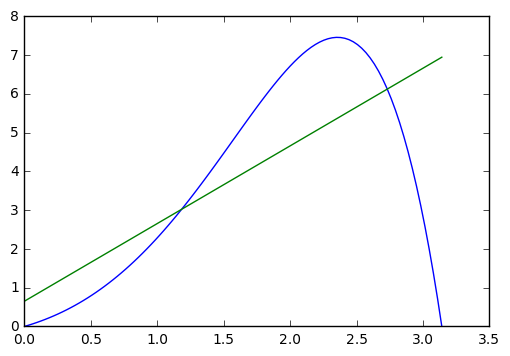

min error at generation n.16: 324.964971275
evolving generation 17 of 100


In [ ]:
%%time
e = evolution(data, 100)
print(e)
# Export resulting graph to json file
# You can view it by starting a webserver(python2 -m SimpleHTTPServer) and then going to http://localhost:8000/graph_viewer.html
e["specimen"].export_json()
print("fittest specimen:")
e["specimen"].draw()
e["specimen"].plot_optimized(data)

In [22]:
#GRAPH PARAMETER OPTIMIZATION TEST
pylab.close()
x = np.linspace(-10,10,100)
y = 2*x
pylab.plot(x,y)
data = {"x":x,"y":y}
#lib[7] is the A*B graph
%lprun -f optimize optimize(lib[7]["graph"],data,0)

{'iterations': 51, 'parameters': array([ 0.81006931,  2.04725724]), 'error': 7.5945441550180899, 'X': 0}


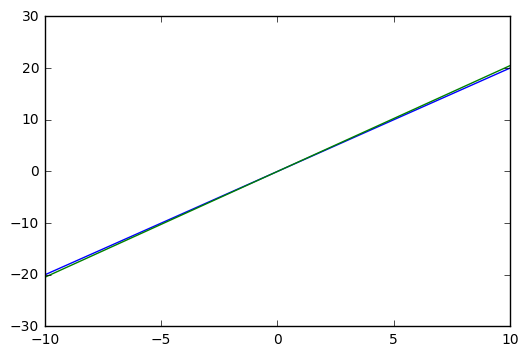

In [416]:
#GRAPH PARAMETER OPTIMIZATION TEST
pylab.close()
x = np.linspace(-10,10,100)
y = 2*x
pylab.plot(x,y)
data = {"x":x,"y":y}
#lib[7] is the A*B graph
result = optimize(lib[7]["graph"],data,0)
print(result)
values = result["parameters"]
x_pos = result["X"]
#input_size*number_of_data_points matrix that contains a list of input vectors like [parameter1, parameter2, x_value, ...]
value_matrix = [[(xe if v == x_pos else value) for v, value in enumerate(values)] for xe in x]
y = np.array([ evaluate(lib[7]["graph"],value_matrix[i]) for i in range(len(value_matrix)) ])
pylab.plot(x,y)
pylab.show()

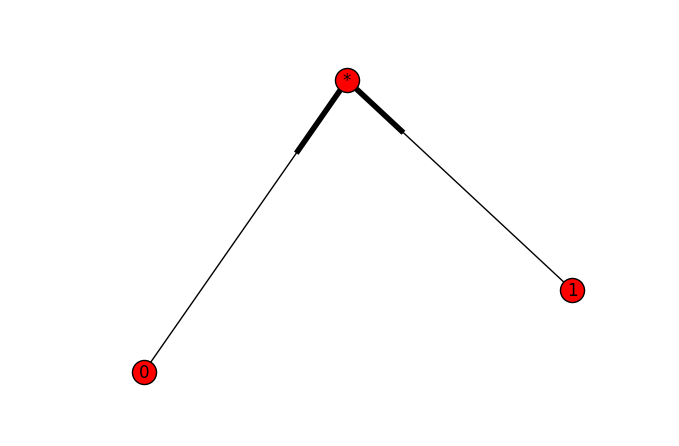

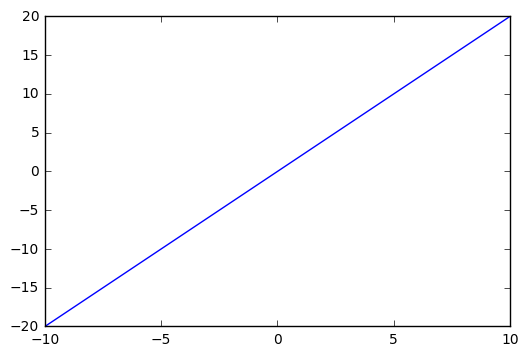

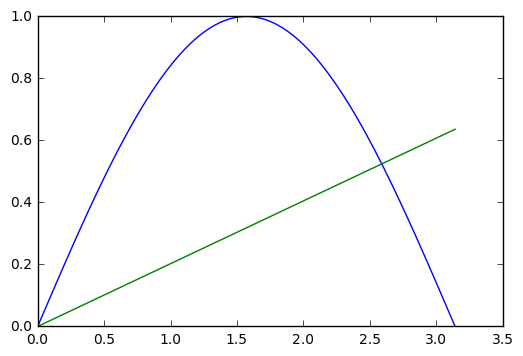

In [352]:
draw(lib[7]["graph"])
plot_specimen(lib[7]["graph"],[2,2])
pylab.close()
x = np.linspace(-10,10,100)
y = 2*x
plot_optimized(lib[7]["graph"],data)

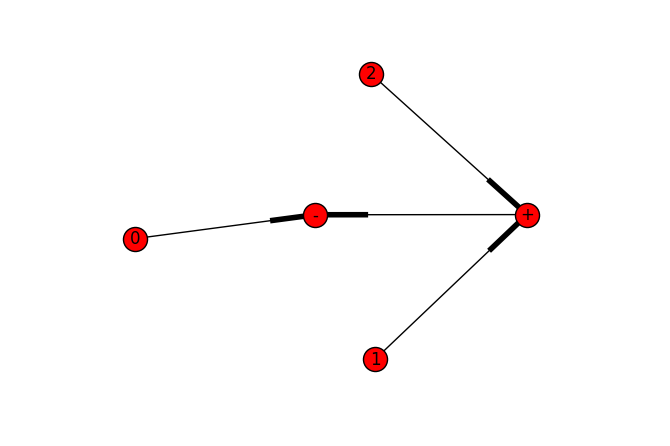

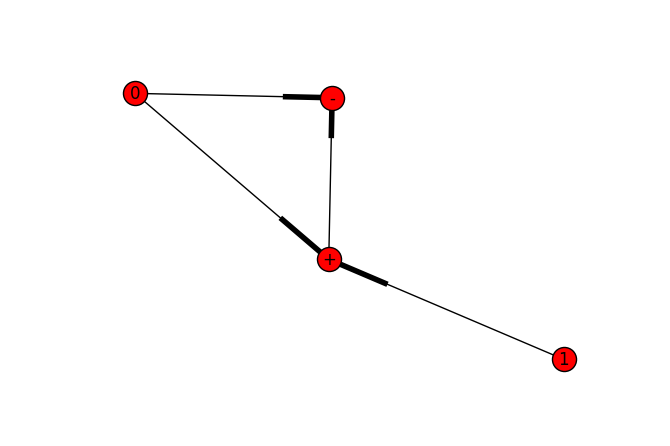

In [353]:
g3 = insert_at(lib[5]["graph"],lib[6]["graph"])
draw(g3)
g4 = merge_input_entries(g3)
draw(g4)

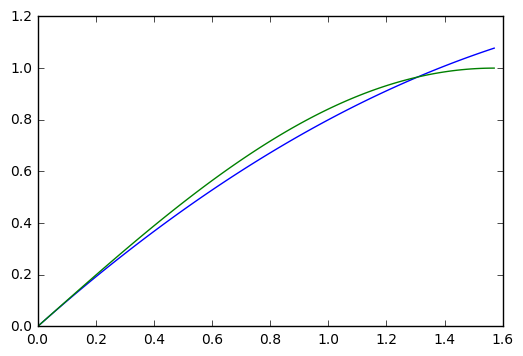

In [357]:
pylab.close()
x = np.linspace(0,math.pi/2,100)
y = x-0.2*x**2
pylab.plot(x,y)
y = np.sin(x)
pylab.plot(x,y)
pylab.show()